# X-Ray Image Classification Project

Phase 4 Project by Bella Scribner
- Flex/
- Instructor: Morgan Jones
- Bog:
- Date of Review:

# Abstract

# Introduction

## The Business Problem


### Pneumonia
- Who is the business and what is the project about and why?  What is the business looking for?  (what evaluation metrics might be most applicable based on this evaluation?)

[WHO](https://www.who.int/news-room/fact-sheets/detail/pneumonia)
[UNICEF](https://www.unicef.org/stories/childhood-pneumonia-explained)

- "biggest infectious killer of children worldwide"
- "more than 725,000 children under age of 5, including around 190,000 newborns, who are particularly vulnerable to infection"

- bacterial, fungal, or viral (different kinds)
- infection of the lungs which fill up with liquid (alveoli fill with pus and fluid) --> makes breathing painful and limits oxygen intake

- deaths highest in southern Asia + sub-Saharan Africa -- concentrated in the world's poorest countries
- areas without strong health care systems health workers often rely on diagnosing pneumonia by counting # of breath per min.  (few doctors, lack of access to chest x-rays + labs)
    - MAKES IDEA OF THIS PROJECT HARD --> idea is to expand access to health care, make it easier to diagnose, but this project needs an x-ray which then limits who can benefit from it...

- treatment depends on type of --> antibiotics if bacterial (most common), oxygen if available (for all types, but generally only more sever cases)

- chest x-rays are used to diagnos pneumonia based on the inflamation of the lungs
- [RadiologyInfo.org](https://www.radiologyinfo.org/en/info/pneumonia#:~:text=When%20interpreting%20the%20x%2Dray,(fluid%20surrounding%20the%20lungs).)
- look for white spots in the lungs (called infilrates) that id an infection)  also helps determine if have complications related to pneumonia such as abscesses or pleural effusions (fluid surrounding the lungs)

### The Business + Project

- [UNICEF Venture Fund](https://www.unicef.org/innovation/venturefund/ai-ds-learning-health-cohort)
- [UNICEF Neural Labs Africa](https://www.unicefventurefund.org/story/neural-labs-using-ai-accelerate-medical-imaging-diagnosis-respiratory-diseases)
- [Neural Labs Africa](https://neurallabs.africa/#)

- In April 2022, UNICEF Venture Fund annouced most recent investments, whic included investing in a company called Neural Labs Africa.  Neural Labs Africa is focused on using deep learning and computer vision to identify diseases in real time.  

- That is the inspiration for this project!  Want to us AI screening to improve patient care. :D 

- This project --> create a model that can be used as a pre-screening for patients, giving a prediction on whether or not the patient has pneumonia.  Based on the seriousness of pneumonia in children, will want to evaluate our model with more than just accuracy -- think precision :)

## The Data Source

- Reproducability!  Make sure to include how to download/access. Also note which versions using in this lab of each python library.

- Data Downloaded from Kaggle: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)

# Data Exploration

## The overview
- From notes of last review --> keep this more contextual and word driven on the front end.  Can talk about results on the back end but want it mostly connected to the header!  
- Don't forget to include target distribution as well as visuals of data in general.



## Detailed exploration

- image sample
- distribution of target

In [1]:
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(88)

#import pandas as pd

#import tensorflow as tf
#from keras.models import Sequential
#from keras import layers


In [2]:
# Versions

In [2]:
# structure of downloaded data
print(os.listdir('./chest_xray'))

# structure of train folder
print(os.listdir('./chest_xray/train'))

['chest_xray', 'test', 'train', 'val', '__MACOSX']
['NORMAL', 'PNEUMONIA']


In [3]:
print(len(os.listdir('./chest_xray/train/NORMAL')))

1341


Looks like we have our data structured such that it is already divided into Train, Validation, and Test segments.  Within those folders the images are stored in two folders based on whether the image is one where pneumonia is present or not.  Let's take a look at the distribution of our target within the train data.

In [4]:
len_normal_train = len(os.listdir('./chest_xray/train/NORMAL'))
len_pneu_train = len(os.listdir('./chest_xray/train/PNEUMONIA'))
len_total_train = len_normal_train + len_pneu_train

print("There are", len_normal_train, "normal xrays in the training set.")
print("There are", len_pneu_train, "pneumonia xrays in the training set.")
print("There are", len_total_train, "images total in the training set.\n")

print('Target Distributon:')
print('{}% normal'.format(round(len_normal_train/len_total_train * 100, 2)))
print('{}% pneumonia'.format(round(len_pneu_train/len_total_train * 100, 2)))

There are 1341 normal xrays in the training set.
There are 3875 pneumonia xrays in the training set.
There are 5216 images total in the training set.

Target Distributon:
25.71% normal
74.29% pneumonia


In [5]:
len_normal_val = len(os.listdir('./chest_xray/val/NORMAL'))
len_pneu_val = len(os.listdir('./chest_xray/val/PNEUMONIA'))
len_total_val = len_normal_val + len_pneu_val

len_normal_test = len(os.listdir('./chest_xray/test/NORMAL'))
len_pneu_test = len(os.listdir('./chest_xray/test/PNEUMONIA'))
len_total_test = len_normal_test + len_pneu_test

print("There are", len_total_val, "images total in the validation set.")
print("There are", len_total_test, "images total in the test set.")

There are 16 images total in the validation set.
There are 624 images total in the test set.


In [6]:
num_images_total = len_total_train + len_total_val + len_total_test
print('Using {}% of data to train'.format(round(len_total_train / num_images_total *100,2)))
print('Using {}% of data to validate'.format(round(len_total_val / num_images_total *100,2)))
print('Using {}% of data to test'.format(round(len_total_test / num_images_total *100,2)))

Using 89.07% of data to train
Using 0.27% of data to validate
Using 10.66% of data to test


So it looks like we do not have a very good split between our training and validation data -- having only 16 images / less than 1% of our data to validate with will lead to higher variance in our evaluation metrics when trying to optimize our models.  

Need to move random 5% of train/pneumonia images and 5% of train/normal images into corresponding validation folder to fix this distribution.

In [7]:
# How many images to move over -- 10% of total train data.  
# Note that this will make our imbalance in the train data WORSE -- will address this imbalance when augment more data later
len_total_train * .1  / 2

260.8

In [7]:
# Create lists of file names for train normal + train pneumonia

normal_train_images = [file for file in os.listdir('./chest_xray/train/NORMAL')]
pneu_train_images = [file for file in os.listdir('./chest_xray/train/PNEUMONIA')]

# randomly choose indicies for 5% of data (both normal + pneumonia)
normal_inds = np.random.choice(range(len_normal_train), size=260, replace=False)
pneu_inds = np.random.choice(range(len_pneu_train), size=260, replace=False)

In [8]:
# move chosen images to validatoin folders
## Uncomment cell and run code

#for i in normal_inds:
#    image = normal_train_images[i]
#    origin = './chest_xray/train/NORMAL/' + image
#    destination = './chest_xray/val/NORMAL/' + image
#    shutil.move(origin, destination)
    
#for i in pneu_inds:
#    image = pneu_train_images[i]
#    origin = './chest_xray/train/PNEUMONIA/' + image
#    destination = './chest_xray/val/PNEUMONIA/' + image
#    shutil.move(origin, destination)

In [10]:
len_normal_train = len(os.listdir('./chest_xray/train/NORMAL'))
len_pneu_train = len(os.listdir('./chest_xray/train/PNEUMONIA'))
len_total_train = len_normal_train + len_pneu_train

len_normal_val = len(os.listdir('./chest_xray/val/NORMAL'))
len_pneu_val = len(os.listdir('./chest_xray/val/PNEUMONIA'))
len_total_val = len_normal_val + len_pneu_val

len_normal_test = len(os.listdir('./chest_xray/test/NORMAL'))
len_pneu_test = len(os.listdir('./chest_xray/test/PNEUMONIA'))
len_total_test = len_normal_test + len_pneu_test

print("There are", len_total_train, "images total in the training set.")
print("There are", len_total_val, "images total in the validation set.")
print("There are", len_total_test, "images total in the test set.\n")

num_images_total = len_total_train + len_total_val + len_total_test
print('Using {}% of data to train'.format(round(len_total_train / num_images_total *100,2)))
print('Using {}% of data to validate'.format(round(len_total_val / num_images_total *100,2)))
print('Using {}% of data to test'.format(round(len_total_test / num_images_total *100,2)))

There are 4696 images total in the training set.
There are 536 images total in the validation set.
There are 624 images total in the test set.

Using 80.19% of data to train
Using 9.15% of data to validate
Using 10.66% of data to test


That isn't quite 80/10/10 split, but much better than before and will be a good split for this project.

In [2]:
# take a look at some images

train_dir = 'chest_xray/train'
val_dir = 'chest_xray/test'
test_dir = 'chest_xray/val'

# all images will be rescaled by 1./225
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    # resize images down to 150x150
                                                    target_size=(150,150),
                                                    # process in 8 batches
                                                    batch_size=587,
                                                    # target is binary
                                                    class_mode='binary')

#val_generator = val_datagen.flow_from_directory(val_dir,
#                                                target_size=(150,150),
#                                                batch_size=67,
#                                                class_mode='binary')

#test_generator = test_datagen.flow_from_directory(test_dir,
#                                                  target_size=(150,150),
#                                                  batch_size=78,
#                                                  class_mode='binary')

Found 4696 images belonging to 2 classes.


In [3]:
# Create a data set for visualization
train_images, train_labels = next(train_generator)
# val_images, val_labels = next(val_generator)
# test_images, test_labels = next(test_generator)

In [4]:
train_images.shape

(587, 150, 150, 3)

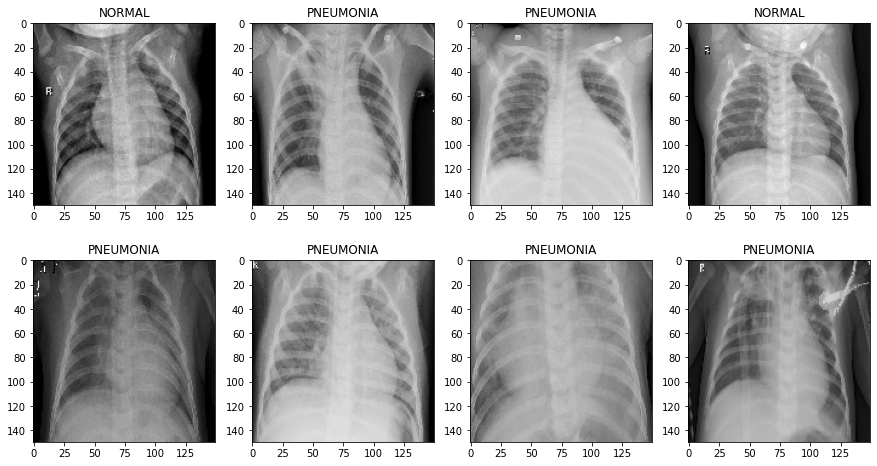

In [5]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15,8))
classes = list(train_generator.class_indices.keys())

for i in range(8):
    row = i // 4 
    col = i % 4
    ax = axes[row, col]

    ax.imshow(train_images[i])
    label = int(train_labels[i])
    ax.set_title(classes[label])

# Model Iteration

## Baseline Model

- Baseline model is Dense Neural Network -- then will iterate through a CNN, then optimize that CNN (assuming does better)

- Build Model (Dense model as base line -- convolutonal in further iterations
- Evaluate with loss + accuracy curves

In [ ]:
# Because baseline model using is a dense NN, will need to reshape data arrays prior to modeling

## Model 2

- CNN


In [17]:
# CNNs take in the image itself (not reshaped) as the input

## Model 3

- optimize CNN (assuming better than Dense NN)



# Final Model Evaluation

## Recommendations